## Letter Model (LDA, Mallet LDA and Author-Topic)

In [4]:
# Get Resources
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import AuthorTopicModel

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

## Stopwords

In [5]:
# Get 19th century stopwords
stop_words = pd.read_csv("jockers.csv")
stop_words = stop_words['word'].values.astype(str).tolist()
len(stop_words)

5631

During author-topic modeling, the proper name carrother appeared frequently. It will be added to the stop_word list, which contains other proper names. 

In [6]:
#Add this term to stop_words list.
stop_words.append("carrothers")
len(stop_words)

5632

In [7]:
stop_words.sort()

In [8]:
stop_words

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'aaron',
 'abbey',
 'abbie',
 'abby',
 'abdul',
 'abe',
 'abel',
 'abigail',
 'about',
 'above',
 'abraham',
 'abram',
 'abst',
 'accordance',
 'according',
 'across',
 'act',
 'actually',
 'ada',
 'adah',
 'adalberto',
 'adaline',
 'adam',
 'adan',
 'added',
 'addie',
 'adela',
 'adelaida',
 'adelaide',
 'adele',
 'adelia',
 'adelina',
 'adeline',
 'adell',
 'adella',
 'adelle',
 'adena',
 'adina',
 'adj',
 'adolfo',
 'adolph',
 'adopted',
 'adria',
 'adrian',
 'adriana',
 'adriane',
 'adrianna',
 'adrianne',
 'adrien',
 'adriene',
 'adrienne',
 'after',
 'afterwards',
 'afton',
 'again',
 'against',
 'agatha',
 'agnes',
 'agnus',
 'agripina',
 'agueda',
 'agustin',
 'agustina',
 'ahmad',
 'ahmed',
 'ai',
 'aida',
 'aide',
 'aiko',
 'aileen',
 'ailene',
 'aimee',
 'aisha',
 'aja',
 'akiko',
 'akilah',
 'al',
 'alaina',
 'alaine',
 'alan',
 'alana',
 'alane',
 'alanna',
 'alayna',
 'alba',
 'albert',
 'alberta',
 'alber

## Get Data

In [9]:
# Sentence Data
df = pd.read_csv("20210125_AM_Data4MalletLDA.csv") 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915 entries, 0 to 914
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     915 non-null    int64 
 1   docid          915 non-null    object
 2   docauthorid    915 non-null    object
 3   allsubject     915 non-null    object
 4   broadsubj      915 non-null    object
 5   personalevent  162 non-null    object
 6   letterText     915 non-null    object
dtypes: int64(1), object(6)
memory usage: 50.2+ KB


In [10]:
# Change column name to "docID-AT"
df = df.rename(columns={'Unnamed: 0':'docID-AT'})
list(df)

['docID-AT',
 'docid',
 'docauthorid',
 'allsubject',
 'broadsubj',
 'personalevent',
 'letterText']

## Modeling

Code adapated from https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920

In [11]:
# Convert values in sentencecs to list of strings (objects)
data = df.letterText.values.tolist()
data[20]

" 15 may 1843 dear heinrich: now last, but not least, a few lines to you! you will have wondered why bernhard suddenly came to his decision. even though it upsets me, i am rather pleased that he has done this rather than stay and settle on his farm. i think you will set him straight, so that we will receive him back quite active and social. it is not likely that he will stay with you, and i would not want that to happen. i am happy that you shall see each other and shall chat with each other cozily. i shall be with you in spirit. mrs bruns is a very wicked woman (bernhard also knows that); by the way, i would have liked to cross out the thing concerning the stockings, and it was certainly not meant with any evil intention. but i really thought that the purchase would be left in part to you. this makes me sad and therefore the following. you certainly know that i have an impetuous and critical nature, but it is not very deep and a single word of opposition would change it. i hope that i

In [12]:
# Define function to convert texts into a list of lowercase tokens
def letter_to_words(letters):
    for letter in letters:
        yield(gensim.utils.simple_preprocess(str(letter), 
                                             deacc=True, # removes accents
                                             min_len=3))   # removes tokens shorter than three characters

data_words = list(letter_to_words(data))

print(data_words[:1])

[['baltimore', 'september', 'dear', 'heinrich', 'friday', 'evening', 'september', 'anchor', 'was', 'dropped', 'and', 'had', 'safely', 'arrived', 'the', 'harbor', 'was', 'long', 'and', 'arduous', 'voyage', 'however', 'were', 'and', 'are', 'all', 'well', 'and', 'thank', 'the', 'father', 'heaven', 'that', 'has', 'protected', 'far', 'had', 'written', 'down', 'the', 'events', 'the', 'voyage', 'for', 'you', 'but', 'great', 'annoyance', 'now', 'missing', 'the', 'whole', 'notebook', 'perhaps', 'will', 'find', 'later', 'you', 'know', 'set', 'sail', 'july', 'the', 'afternoon', 'when', 'the', 'pilot', 'left', 'one', 'after', 'the', 'other', 'began', 'hold', 'his', 'head', 'overboard', 'bernhard', 'mrs', 'schwarze', 'the', 'children', 'and', 'others', 'the', 'next', 'morning', 'felt', 'ill', 'and', 'remained', 'bed', 'for', 'two', 'days', 'but', 'during', 'the', 'whole', 'time', 'only', 'had', 'vomit', 'four', 'five', 'times', 'this', 'was', 'pretty', 'much', 'the', 'same', 'with', 'most', 'passen

In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=20, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [16]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_md
nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])

In [17]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN']) # Per Jockers & Mimno (2013)

In [43]:
# Save this for later
import pickle

In [39]:
with open("dataLemmatized.txt", "wb") as fp:   #Pickling
    pickle.dump(data_lemmatized, fp)

In [44]:
 # Get it back
with open("dataLemmatized.txt", "rb") as fp:   # Unpickling
    data_lemmatized = pickle.load(fp)

In [40]:
print(data_words_nostops[:1])

[['baltimore', 'dear', 'heinrich', 'friday', 'evening', 'anchor', 'dropped', 'safely', 'arrived', 'harbor', 'arduous', 'voyage', 'thank', 'father', 'heaven', 'protected', 'written', 'events', 'voyage', 'annoyance', 'missing', 'notebook', 'find', 'set', 'sail', 'july', 'afternoon', 'pilot', 'began', 'hold', 'head', 'overboard', 'bernhard', 'schwarze', 'children', 'morning', 'felt', 'remained', 'bed', 'days', 'time', 'vomit', 'times', 'pretty', 'passengers', 'spared', 'wind', 'adverse', 'evening', 'remained', 'weeks', 'pass', 'english', 'channel', 'cope', 'heavy', 'weather', 'north', 'sea', 'open', 'sea', 'things', 'fine', 'sailed', 'southward', 'experienced', 'calm', 'heat', 'longing', 'reach', 'land', 'possible', 'greater', 'greater', 'water', 'bad', 'food', 'appetizing', 'ham', 'sufficient', 'wine', 'lots', 'things', 'lacking', 'pitied', 'dined', 'hermann', 'noon', 'captain', 'cabin', 'heat', 'sat', 'kirchberg', 'scarcely', 'shade', 'deck', 'ossenbeck', 'everswinkel', 'happily', 'deli

In [41]:
print(data_words_bigrams[:1])

[['baltimore', 'dear', 'heinrich', 'friday', 'evening', 'anchor', 'dropped', 'safely', 'arrived', 'harbor', 'arduous', 'voyage', 'thank', 'father', 'heaven', 'protected', 'written', 'events', 'voyage', 'annoyance', 'missing', 'notebook', 'find', 'set', 'sail', 'july', 'afternoon', 'pilot', 'began', 'hold', 'head', 'overboard', 'bernhard', 'schwarze', 'children', 'morning', 'felt', 'remained', 'bed', 'days', 'time', 'vomit', 'times', 'pretty', 'passengers', 'spared', 'wind', 'adverse', 'evening', 'remained', 'weeks', 'pass', 'english', 'channel', 'cope', 'heavy', 'weather', 'north', 'sea', 'open', 'sea', 'things', 'fine', 'sailed', 'southward', 'experienced', 'calm', 'heat', 'longing', 'reach', 'land', 'possible', 'greater', 'greater', 'water', 'bad', 'food', 'appetizing', 'ham', 'sufficient', 'wine', 'lots', 'things', 'lacking', 'pitied', 'dined', 'hermann', 'noon', 'captain', 'cabin', 'heat', 'sat', 'kirchberg', 'scarcely', 'shade', 'deck', 'ossenbeck', 'everswinkel', 'happily', 'deli

In [42]:
print(data_lemmatized[:1])

[['evening', 'anchor', 'harbor', 'voyage', 'event', 'voyage', 'annoyance', 'notebook', 'find', 'sail', 'afternoon', 'pilot', 'head', 'child', 'morning', 'bed', 'day', 'time', 'vomit', 'time', 'passenger', 'wind', 'evening', 'week', 'channel', 'weather', 'sea', 'thing', 'heat', 'longing', 'reach', 'land', 'water', 'food', 'ham', 'wine', 'lot', 'thing', 'heat', 'shade', 'deck', 'attendance', 'chaplain', 'name', 'noon', 'meal', 'schniederjan', 'fish', 'dolphin', 'beef', 'steak', 'day', 'beef', 'trip', 'pilot', 'ship', 'cape', 'evening', 'lie', 'firm', 'soil', 'note', 'fruit', 'night', 'morning', 'church', 'heart', 'minute', 'church', 'hour', 'chaplain', 'steerage', 'passenger', 'hour', 'time', 'assistant', 'bench', 'people', 'time', 'gospel', 'quarantine', 'heat', 'day', 'thought', 'deal', 'trouble', 'brother', 'yesterday', 'morning', 'good', 'wagon', 'back', 'country', 'hunter', 'mood', 'freight', 'wagon', 'seat', 'tomorrow', 'travel', 'day', 'wing', 'letter', 'greeting', 'brother', 'sis

## LDA Model

In [45]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [221]:
# View
corpus[:1]

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 2),
  (8, 1),
  (9, 4),
  (10, 1),
  (11, 1),
  (12, 2),
  (13, 1),
  (14, 2),
  (15, 1),
  (16, 4),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 3),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 2),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 3),
  (37, 2),
  (38, 1),
  (39, 1),
  (40, 2),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 3),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 2),
  (54, 1),
  (55, 2),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 2),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 2),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 2),
  (71, 1),
  (72, 4),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 3),
  (79, 2),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1)]]

In [222]:
id2word[7]

'beef'

In [223]:
id2word.id2token

{0: 'afternoon',
 1: 'anchor',
 2: 'annoyance',
 3: 'assistant',
 4: 'attendance',
 5: 'back',
 6: 'bed',
 7: 'beef',
 8: 'bench',
 9: 'brother',
 10: 'cape',
 11: 'channel',
 12: 'chaplain',
 13: 'child',
 14: 'church',
 15: 'country',
 16: 'day',
 17: 'deal',
 18: 'deck',
 19: 'detail',
 20: 'dolphin',
 21: 'evening',
 22: 'event',
 23: 'find',
 24: 'firm',
 25: 'fish',
 26: 'food',
 27: 'freight',
 28: 'fruit',
 29: 'good',
 30: 'gospel',
 31: 'greeting',
 32: 'ham',
 33: 'harbor',
 34: 'head',
 35: 'heart',
 36: 'heat',
 37: 'hour',
 38: 'hunter',
 39: 'land',
 40: 'letter',
 41: 'lie',
 42: 'longing',
 43: 'lot',
 44: 'meal',
 45: 'minute',
 46: 'mood',
 47: 'morning',
 48: 'name',
 49: 'night',
 50: 'noon',
 51: 'note',
 52: 'notebook',
 53: 'passenger',
 54: 'people',
 55: 'pilot',
 56: 'property',
 57: 'quarantine',
 58: 'reach',
 59: 'relative',
 60: 'sail',
 61: 'schniederjan',
 62: 'sea',
 63: 'seat',
 64: 'shade',
 65: 'ship',
 66: 'sister',
 67: 'soil',
 68: 'steak',
 69: 

In [224]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('afternoon', 1),
  ('anchor', 1),
  ('annoyance', 1),
  ('assistant', 1),
  ('attendance', 1),
  ('back', 1),
  ('bed', 1),
  ('beef', 2),
  ('bench', 1),
  ('brother', 4),
  ('cape', 1),
  ('channel', 1),
  ('chaplain', 2),
  ('child', 1),
  ('church', 2),
  ('country', 1),
  ('day', 4),
  ('deal', 1),
  ('deck', 1),
  ('detail', 1),
  ('dolphin', 1),
  ('evening', 3),
  ('event', 1),
  ('find', 1),
  ('firm', 1),
  ('fish', 1),
  ('food', 1),
  ('freight', 1),
  ('fruit', 1),
  ('good', 1),
  ('gospel', 1),
  ('greeting', 2),
  ('ham', 1),
  ('harbor', 1),
  ('head', 1),
  ('heart', 1),
  ('heat', 3),
  ('hour', 2),
  ('hunter', 1),
  ('land', 1),
  ('letter', 2),
  ('lie', 1),
  ('longing', 1),
  ('lot', 1),
  ('meal', 1),
  ('minute', 1),
  ('mood', 1),
  ('morning', 3),
  ('name', 1),
  ('night', 1),
  ('noon', 1),
  ('note', 1),
  ('notebook', 1),
  ('passenger', 2),
  ('people', 1),
  ('pilot', 2),
  ('property', 1),
  ('quarantine', 1),
  ('reach', 1),
  ('relative', 1),
  (

In [225]:
# Build author-topic model for 3 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=24, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=8,
                                           alpha='auto',
                                           eta = 'auto',
                                           per_word_topics=True)

In [226]:
# Print the keywords for 3 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(10,
  '0.000*"sister" + 0.000*"time" + 0.000*"letter" + 0.000*"year" + '
  '0.000*"blow" + 0.000*"laugh" + 0.000*"child" + 0.000*"day" + 0.000*"friend" '
  '+ 0.000*"week"'),
 (5,
  '0.000*"sister" + 0.000*"time" + 0.000*"man" + 0.000*"day" + 0.000*"room" + '
  '0.000*"place" + 0.000*"work" + 0.000*"door" + 0.000*"patient" + '
  '0.000*"prisoner"'),
 (23,
  '0.019*"grandfather" + 0.003*"befell" + 0.001*"version" + 0.000*"stepmother" '
  '+ 0.000*"grandmother" + 0.000*"feed" + 0.000*"crop" + 0.000*"struggle" + '
  '0.000*"time" + 0.000*"year"'),
 (21,
  '0.012*"reporting" + 0.006*"hermit" + 0.001*"shout" + 0.001*"catalpa" + '
  '0.001*"canary" + 0.001*"hearing" + 0.000*"reunion" + 0.000*"cat" + '
  '0.000*"read" + 0.000*"ottilie"'),
 (2,
  '0.049*"tariff" + 0.019*"holding" + 0.011*"humility" + 0.000*"sister" + '
  '0.000*"day" + 0.000*"year" + 0.000*"letter" + 0.000*"mother" + 0.000*"time" '
  '+ 0.000*"befall"'),
 (14,
  '0.021*"examination" + 0.007*"railing" + 0.006*"prevent" + 0.00

In [227]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.728193376921887

Coherence Score:  0.42880857032646275


In [229]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
17    -0.285196  0.015343       1        1  38.450347
8     -0.317367 -0.038280       2        1  15.160248
0     -0.364363  0.104262       3        1  13.984393
3     -0.264866  0.067119       4        1  13.405141
12    -0.298547  0.039827       5        1   7.252186
16    -0.270432  0.095195       6        1   3.758504
15    -0.045662 -0.286007       7        1   2.035298
13    -0.069808 -0.268310       8        1   1.878713
9     -0.072861 -0.086431       9        1   1.817671
1      0.112889  0.024323      10        1   0.677972
20     0.132545  0.028835      11        1   0.440883
7      0.136026  0.033212      12        1   0.310712
11     0.138240  0.024840      13        1   0.190345
18     0.142202  0.030175      14        1   0.186692
19     0.139217  0.024694      15        1   0.118616
4      0.137692  0.025254      16        1   0.092706
6      0.135312  0.023410      17        1   0.057137
14     0.131680  0.021477      18        1   0.046099
22     0.132589  0.021452      19        1   0.034150
2      0.133613  0.022226      20        1   0.029993
23     0.129925  0.019765      21        1   0.026002
21     0.130049  0.019853      22        1   0.023139
5      0.128561  0.018884      23        1   0.011620
10     0.128561  0.018883      24        1   0.011433, topic_info=        Term         Freq        Total Category  logprob  loglift
40    letter  1511.000000  1511.000000  Default  30.0000  30.0000
212     work   943.000000   943.000000  Default  29.0000  29.0000
121   dollar   744.000000   744.000000  Default  28.0000  28.0000
39      land   723.000000   723.000000  Default  27.0000  27.0000
214     year  1602.000000  1602.000000  Default  26.0000  26.0000
...      ...          ...          ...      ...      ...      ...
473    month     0.001592   647.643252  Topic24  -8.9561  -3.8397
35     heart     0.001592   336.583369  Topic24  -8.9561  -3.1852
3673    monk     0.001592     6.461809  Topic24  -8.9561   0.7678
1037    call     0.001592    99.619531  Topic24  -8.9561  -1.9677
203    uncle     0.001592    91.956782  Topic24  -8.9561  -1.8876

[1315 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
3477     10  0.943867        abound
87        1  0.246436  acquaintance
87        3  0.710872  acquaintance
87        5  0.037913  acquaintance
88        5  0.995797          acre
...     ...       ...           ...
214       6  0.014973          year
86        1  0.042430     yesterday
86        2  0.700089     yesterday
86        3  0.206845     yesterday
86        9  0.047733     yesterday

[1581 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[18, 9, 1, 4, 13, 17, 16, 14, 10, 2, 21, 8, 12, 19, 20, 5, 7, 15, 23, 3, 24, 22, 6, 11])

## LDA Mallet Models

This code adapted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [45]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path

In [61]:
# Run model
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=24, id2word=id2word)

# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(11,
  [('water', 0.035897435897435895),
   ('foot', 0.028599605522682446),
   ('gold', 0.027810650887573965),
   ('tree', 0.026232741617357003),
   ('place', 0.022682445759368838),
   ('mountain', 0.020118343195266272),
   ('country', 0.015779092702169626),
   ('work', 0.014398422090729782),
   ('grass', 0.014201183431952662),
   ('bar', 0.013609467455621301)]),
 (7,
  [('city', 0.03518859245630175),
   ('building', 0.027598896044158234),
   ('people', 0.025758969641214352),
   ('purpose', 0.02276908923643054),
   ('street', 0.02230910763569457),
   ('fact', 0.01954921803127875),
   ('man', 0.017709291628334865),
   ('house', 0.01655933762649494),
   ('day', 0.01609935602575897),
   ('business', 0.013799448022079117)]),
 (16,
  [('place', 0.06788952139995784),
   ('house', 0.047016656124815516),
   ('town', 0.0457516339869281),
   ('day', 0.03310141260805397),
   ('river', 0.025511279780729496),
   ('boat', 0.025511279780729496),
   ('wood', 0.02066202825216108),
   ('store', 0.02002

In [47]:
# Convert results to lda model format for visualization.
MalletLDA24 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [48]:
ldamallet.save('MalletLDA24')

In [49]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(MalletLDA24, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.007279 -0.012091       1        1  5.221412
5      0.108082  0.061966       2        1  4.942758
21     0.000853  0.266923       3        1  4.915079
6     -0.002793  0.133661       4        1  4.723252
20     0.269793 -0.062795       5        1  4.716725
16     0.087518  0.096544       6        1  4.680723
0     -0.038187  0.233215       7        1  4.553909
8     -0.085834 -0.104172       8        1  4.553162
17     0.268621  0.036831       9        1  4.552850
14     0.070472  0.022559      10        1  4.400847
22     0.010981 -0.003414      11        1  4.358423
12    -0.019143 -0.002083      12        1  4.232340
3     -0.088972  0.149057      13        1  3.981952
15    -0.127658 -0.011543      14        1  3.922766
18    -0.157759 -0.015420      15        1  3.882677
23    -0.022334 -0.033274      16        1  3.851076
13     0.123068 -0.052842      17        1  3.792672
7     -0.153515 -0.092632      18        1  3.777931
11    -0.110470 -0.204559      19        1  3.719423
2     -0.044719 -0.019510      20        1  3.683329
9     -0.062333 -0.230566      21        1  3.627207
1     -0.148452  0.131656      22        1  3.412399
19     0.246552 -0.171009      23        1  3.322752
4     -0.131051 -0.116502      24        1  3.174333, topic_info=         Term         Freq        Total Category  logprob  loglift
40     letter  1329.000000  1329.000000  Default  30.0000  30.0000
66     sister   963.000000   963.000000  Default  29.0000  29.0000
13      child   941.000000   941.000000  Default  28.0000  28.0000
16        day  1597.000000  1597.000000  Default  27.0000  27.0000
54     people   915.000000   915.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
501    spirit    39.124398   152.580708  Topic24  -4.4730   2.0891
370    mother    57.181813   417.240229  Topic24  -4.0935   1.4626
480    parent    32.102070   143.116401  Topic24  -4.6708   1.9553
470  medicine    22.070173    57.932177  Topic24  -5.0455   2.4850
705    remark    20.063794    36.038538  Topic24  -5.1408   2.8644

[2161 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
5800     11  0.984793    abstain
1268      3  0.895784  abundance
1268      8  0.021328  abundance
1268     11  0.042656  abundance
1268     23  0.042656  abundance
...     ...       ...        ...
86       17  0.152450  yesterday
86       19  0.347585  yesterday
86       23  0.500035  yesterday
4572      7  1.047650       yoke
3594     12  1.000783       zinc

[3087 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 6, 22, 7, 21, 17, 1, 9, 18, 15, 23, 13, 4, 16, 19, 24, 14, 8, 12, 3, 10, 2, 20, 5])

In [235]:
p = pyLDAvis.gensim.prepare(MalletLDA24, corpus, id2word)
pyLDAvis.save_html(p, 'MalletLDA24.html')

In [50]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [58]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=3, 
                                                        limit=27, 
                                                        step=1)

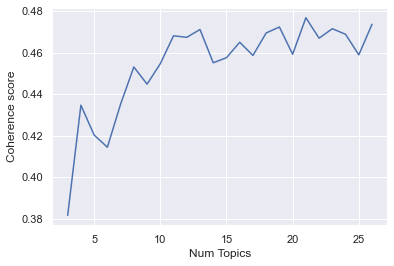

In [189]:
# Show graph
limit=27; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.show()

In [190]:
plt.savefig('20210129_AM_CoherenceScores')

<Figure size 432x288 with 0 Axes>

In [56]:
len(model_list)

24

In [133]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.3815
Num Topics = 4  has Coherence Value of 0.4346
Num Topics = 5  has Coherence Value of 0.4203
Num Topics = 6  has Coherence Value of 0.4144
Num Topics = 7  has Coherence Value of 0.4351
Num Topics = 8  has Coherence Value of 0.453
Num Topics = 9  has Coherence Value of 0.4448
Num Topics = 10  has Coherence Value of 0.4546
Num Topics = 11  has Coherence Value of 0.4681
Num Topics = 12  has Coherence Value of 0.4673
Num Topics = 13  has Coherence Value of 0.4711
Num Topics = 14  has Coherence Value of 0.4551
Num Topics = 15  has Coherence Value of 0.4575
Num Topics = 16  has Coherence Value of 0.465
Num Topics = 17  has Coherence Value of 0.4586
Num Topics = 18  has Coherence Value of 0.4694
Num Topics = 19  has Coherence Value of 0.4723
Num Topics = 20  has Coherence Value of 0.4592
Num Topics = 21  has Coherence Value of 0.4768
Num Topics = 22  has Coherence Value of 0.4669
Num Topics = 23  has Coherence Value of 0.4715
Num Topics = 24  has C

In [135]:
# Coherence for 21-topic model
coherence_values[18]

0.4767654034711632

In [136]:
# Coherence for 21-topic model
malletModel_21 = model_list[18]
model_topics_21 = malletModel_21.show_topics(formatted=False)

In [137]:
pprint(sorted(malletModel_21.print_topics(num_words=10)))

[(0,
  '0.049*"day" + 0.033*"morning" + 0.030*"ship" + 0.026*"hour" + 0.023*"sea" + '
  '0.023*"night" + 0.023*"time" + 0.022*"wind" + 0.021*"water" + '
  '0.021*"evening"'),
 (1,
  '0.046*"city" + 0.035*"house" + 0.029*"town" + 0.027*"building" + '
  '0.022*"street" + 0.019*"place" + 0.016*"shop" + 0.015*"railroad" + '
  '0.014*"work" + 0.014*"business"'),
 (2,
  '0.150*"sister" + 0.026*"man" + 0.018*"room" + 0.017*"hospital" + '
  '0.015*"mother" + 0.015*"place" + 0.013*"patient" + 0.012*"door" + '
  '0.011*"train" + 0.011*"number"'),
 (3,
  '0.291*"letter" + 0.068*"brother" + 0.047*"time" + 0.037*"wife" + '
  '0.032*"health" + 0.026*"news" + 0.025*"mail" + 0.022*"thing" + '
  '0.019*"child" + 0.018*"today"'),
 (4,
  '0.182*"child" + 0.098*"school" + 0.071*"mother" + 0.041*"boy" + '
  '0.039*"time" + 0.028*"teacher" + 0.023*"parent" + 0.017*"music" + '
  '0.014*"picture" + 0.014*"father"'),
 (5,
  '0.046*"book" + 0.028*"paper" + 0.028*"work" + 0.020*"dear" + 0.020*"copy" + '
  '0.020

In [138]:
malletModel_21.save('MalletLDA21')

In [38]:
# For importing back into notebook after close

from gensim.models.wrappers import LdaMallet
malletModel_21 = LdaMallet.load("MalletLDA21")

In [39]:
# Convert results to lda model format for visualization.
MalletLDA21 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(malletModel_21)

In [46]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(MalletLDA21, corpus, id2word, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.234222 -0.016144       1        1  5.273501
1      0.057495 -0.104504       2        1  4.946896
2      0.101396 -0.052860       3        1  5.966383
3     -0.082190  0.278957       4        1  4.192017
4     -0.039447  0.223691       5        1  3.983720
5     -0.006407  0.054936       6        1  4.347765
6     -0.003850  0.124087       7        1  4.670271
7     -0.132778 -0.239025       8        1  5.701106
8      0.094449 -0.065009       9        1  4.539245
9     -0.077717  0.037856      10        1  4.148171
10    -0.116475 -0.072684      11        1  4.281888
11     0.226014  0.067739      12        1  3.717723
12     0.005015 -0.132023      13        1  5.623867
13     0.030793 -0.054490      14        1  4.907286
14    -0.184370 -0.164281      15        1  5.288917
15     0.207190  0.032938      16        1  4.856553
16     0.130064 -0.132282      17        1  4.845470
17    -0.156424  0.133809      18        1  4.480765
18    -0.169513  0.107310      19        1  4.141702
19    -0.203061 -0.087482      20        1  5.189562
20     0.085593  0.059459      21        1  4.897193, topic_info=         Term         Freq        Total Category  logprob  loglift
40     letter  1320.000000  1320.000000  Default  30.0000  30.0000
66     sister   964.000000   964.000000  Default  29.0000  29.0000
13      child   953.000000   953.000000  Default  28.0000  28.0000
214      year  1419.000000  1419.000000  Default  27.0000  27.0000
16        day  1590.000000  1590.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
170     place    86.743811   857.948173  Topic21  -4.1103   0.7249
176    reason    41.876322   161.923338  Topic21  -4.8385   1.6641
604    master    27.917548    52.456604  Topic21  -5.2440   2.3858
581   expense    34.896935   166.605795  Topic21  -5.0209   1.4533
442  clothing    29.911659    83.523679  Topic21  -5.1750   1.9896

[1899 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5658      1  0.966329     abandon
216      20  1.004826     ability
5800      4  1.047080     abstain
1772      7  0.967614       abuse
2808      4  1.047080  accomplice
...     ...       ...         ...
86        4  0.484062   yesterday
86       12  0.503170   yesterday
86       19  0.012738   yesterday
5965     15  1.042652        youe
3594     21  1.002953        zinc

[2617 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [197]:
# Convert pyLDAvis topics to Gensim
topics_pyLDAvis2Gensim = vis.topic_order
topics_pyLDAvis2Gensim = [x - 1 for x in topics_pyLDAvis2Gensim]
print(topics_pyLDAvis2Gensim)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [47]:
pyLDAvis.save_html(vis, 'MalletLDA21.html')

## Author-Topic Model

In [18]:
# Create author2doc dictionary
author2doc = df.groupby(['docauthorid'])['docID-AT'].apply(list).to_dict()

In [19]:
# Create Dictionary
dictionary = corpora.Dictionary(data_lemmatized)
_ = dictionary[0]  # This sort of "initializes" dictionary.id2token.

In [20]:
# Create Corpus
docs = data_lemmatized

In [21]:
# Make bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [22]:
# Verify data
print('Number of authors: %d' % len(author2doc))
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of authors: 218
Number of unique tokens: 7755
Number of documents: 915


In [23]:
# Create doc2author from author2doc
doc2author = gensim.models.atmodel.construct_doc2author(corpus, author2doc)

In [24]:
# Regenerate author2doc from doc2author
# Model was throwing errors otherwise
author2doc = gensim.models.atmodel.construct_author2doc(doc2author)

In [98]:
# Quick run of author-topic model using optimal number of topics from LDA Mallet model.
%time model = AuthorTopicModel(corpus=corpus, num_topics=24, id2word=dictionary.id2token, \
                author2doc=author2doc, chunksize=200, passes=8, update_every=1, \
                iterations=1, random_state=100)

CPU times: user 4.9 s, sys: 583 ms, total: 5.48 s
Wall time: 3.33 s


In [99]:
# View topics and coherence scores.
model.top_topics(texts = docs, dictionary = dictionary, coherence='c_v')

[([(0.020155212298134037, 'worker'),
   (0.018365611028151433, 'rocker'),
   (0.015544547507252966, 'anarchist'),
   (0.013200021285397866, 'ounce'),
   (0.010507589057901489, 'hull'),
   (0.010053727432066638, 'orthography'),
   (0.008929616052101543, 'current'),
   (0.00892961026247583, 'crossing'),
   (0.008928536177402482, 'bowl'),
   (0.00892495859215374, 'motley'),
   (0.008851763197509981, 'fleet'),
   (0.00780118386877075, 'workday'),
   (0.007801138985441816, 'applause'),
   (0.007801132068548536, 'franchise'),
   (0.007801046416657694, 'nationalism'),
   (0.0078008397065120645, 'burning'),
   (0.007800776886868376, 'hobo'),
   (0.007800265685264955, 'storey'),
   (0.00730333458006456, 'steamship'),
   (0.006635813634832927, 'weekday')],
  0.649043992978508),
 ([(0.06142127693629948, 'ship'),
   (0.031111476570852503, 'barrel'),
   (0.028555587417626, 'passenger'),
   (0.027796085802955266, 'board'),
   (0.027399054772494272, 'deck'),
   (0.018120564255467635, 'vein'),
   (0.0

In [25]:
# Rejig the function from above to generate coherence scores for author-topic models with a range of topic counts
def compute_coherence_valuesAT(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of author-topic topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_valuesAT = []
    model_listAT = []
    for num_topics in range(start, limit, step):
        modelAT = AuthorTopicModel(corpus=corpus, num_topics=num_topics, id2word=dictionary.id2token, \
                author2doc=author2doc, chunksize=200, passes=8, update_every=1, \
                iterations=1, random_state=100)
        model_listAT.append(modelAT)
        coherencemodelAT = CoherenceModel(model=modelAT, texts=docs, dictionary=dictionary, coherence='c_v')
        coherence_valuesAT.append(coherencemodelAT.get_coherence())

    return model_listAT, coherence_valuesAT

In [26]:
# Run models and coherence call.
model_listAT, coherence_valuesAT = compute_coherence_valuesAT(dictionary=dictionary, 
                                                        corpus=corpus, 
                                                        texts=docs, 
                                                        start=3, 
                                                        limit=27, 
                                                        step=1)

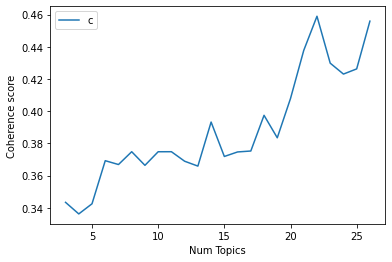

In [27]:
# Show graph
limit=27; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_valuesAT)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values Author-Topic Model"), loc='best')
plt.show()

In [28]:
len(model_listAT)

24

In [31]:
# Print the coherence scores for author topics models
for m, cv in zip(x, coherence_valuesAT):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.3434
Num Topics = 4  has Coherence Value of 0.3362
Num Topics = 5  has Coherence Value of 0.3425
Num Topics = 6  has Coherence Value of 0.3693
Num Topics = 7  has Coherence Value of 0.3669
Num Topics = 8  has Coherence Value of 0.3748
Num Topics = 9  has Coherence Value of 0.3664
Num Topics = 10  has Coherence Value of 0.3748
Num Topics = 11  has Coherence Value of 0.3748
Num Topics = 12  has Coherence Value of 0.3689
Num Topics = 13  has Coherence Value of 0.3659
Num Topics = 14  has Coherence Value of 0.3933
Num Topics = 15  has Coherence Value of 0.3719
Num Topics = 16  has Coherence Value of 0.3747
Num Topics = 17  has Coherence Value of 0.3753
Num Topics = 18  has Coherence Value of 0.3974
Num Topics = 19  has Coherence Value of 0.3835
Num Topics = 20  has Coherence Value of 0.4079
Num Topics = 21  has Coherence Value of 0.4377
Num Topics = 22  has Coherence Value of 0.459
Num Topics = 23  has Coherence Value of 0.4298
Num Topics = 24  has 

In [33]:
# Coherence values
coherence_valuesAT[19]

0.45896721212574776

In [34]:
# Topics for 22-topic author-topic model
ATModel_22 = model_listAT[19]
ATmodel_topics_22 = ATModel_22.show_topics(formatted=False)
pprint(ATModel_22.print_topics(num_words=10))

[(9,
  '0.039*"barrel" + 0.019*"cultivation" + 0.017*"parish" + 0.017*"loyalty" + '
  '0.013*"childhood" + 0.013*"demand" + 0.012*"dollar" + 0.012*"people" + '
  '0.011*"sash" + 0.011*"polling"'),
 (11,
  '0.064*"township" + 0.026*"cotton" + 0.022*"rye" + 0.020*"country" + '
  '0.020*"labourer" + 0.020*"lock" + 0.018*"shilling" + 0.014*"oatmeal" + '
  '0.013*"fish" + 0.013*"blood"'),
 (6,
  '0.038*"meter" + 0.020*"husband" + 0.017*"hatred" + 0.016*"gooseberry" + '
  '0.013*"topsoil" + 0.013*"rake" + 0.011*"pity" + 0.009*"sweetheart" + '
  '0.009*"kilometer" + 0.008*"countryside"'),
 (20,
  '0.042*"wife" + 0.022*"foreman" + 0.019*"rudder" + 0.013*"shop" + '
  '0.012*"ruble" + 0.010*"editor" + 0.010*"surf" + 0.009*"freethinker" + '
  '0.009*"worker" + 0.007*"cantor"'),
 (19,
  '0.045*"husband" + 0.043*"reader" + 0.027*"editor" + 0.018*"child" + '
  '0.016*"hunger" + 0.013*"print" + 0.009*"blacksmith" + 0.009*"goal" + '
  '0.008*"newspaper" + 0.006*"advocate"'),
 (4,
  '0.049*"cell" + 0.0

In [35]:
# Save model.
ATModel_22.save('ATModel_22')

Although slightly closer to the 24-topic system identified by Moreton (2016) and theoretically interesting, the 22-topic author-topic model does not offer a better coherence score and the topics cannot be visualized using pyLDAvis. It seems this might be possible by modifying the /pyLDAvis/gensim.py but I cannot figure out how to do this. Author-topic models are normally used when there are multiple authors per doc, not when there a single-authored docs. For these reasons, the author-topic model will be abandoned (for now) in lieu of the MalletLDA using 21 topics. It might still be an interesting avenue for future research.

In [233]:
def format_topics_letters(ldamodel=MalletLDA21, corpus=corpus, texts=texts):
    # Init output
    letter_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                letter_topics_df = letter_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    letter_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    letter_topics_df = pd.concat([letter_topics_df, contents], axis=1)
    return(letter_topics_df)

In [241]:
# Check the topic for the first 10 rows. 
df_topic_letter_keywords = format_topics_letters(ldamodel=MalletLDA21, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_letter_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head()

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.2635   
1            1            17.0              0.1412   
2            2            17.0              0.3307   
3            3            17.0              0.1682   
4            4            17.0              0.1752   

                                            Keywords  \
0  day, morning, ship, hour, sea, night, time, wi...   
1  thing, time, people, year, lot, house, uncle, ...   
2  thing, time, people, year, lot, house, uncle, ...   
3  thing, time, people, year, lot, house, uncle, ...   
4  thing, time, people, year, lot, house, uncle, ...   

                                                Text  
0   baltimore 20 september 1836 dear heinrich: fr...  
1   tuesday, 14 november 1836 dear heinrich: we a...  
2   westphalia settlement august 1837 dear heinri...  
3   westphalian settlement 7 september '37 dear h...  
4   westphalia settlement 1 march 1838 dear heinr...

In [242]:
map_letterText_topicNumber = {}

In [243]:
for index, item in enumerate(data):
    topic_dist = MalletLDA21.get_document_topics(corpus[index])

    # topic_dist is a list of tuples: each tuple has a topic number with its corresponding proportion
    sorted_topic_dist = sorted(topic_dist, key=lambda x: (x[1]), reverse=True) # Sort it in descending order
    
    # Pick the top one:
    topic_number = sorted_topic_dist[0][0]
    map_letterText_topicNumber[item] = topic_number

In [244]:
map_letterText_topicNumber

{" baltimore 20 september 1836 dear heinrich: friday evening, 16 september, anchor was dropped and we had safely arrived in the harbor! it was a long and arduous voyage! however we were and are all well and thank the father in heaven that he has protected us so far! i had written down the events of the voyage for you, but to my great annoyance i am now missing the whole notebook; perhaps i will find it later. as you know, we set sail on 12 july. by the afternoon, when the pilot left us, one after the other began to hold his head overboard; bernhard, mrs schwarze, the children, and others. the next morning i felt ill and remained in bed for two days, but during the whole time i only had to vomit four or five times; this was pretty much the same with most passengers. later i was always spared. the wind was adverse from the very first evening and remained so for almost three weeks; we did not pass the english channel until 2 august and had to cope with very heavy stormy weather in the nor

In [245]:
df['topicNumber'] = df['letterText'].map(map_letterText_topicNumber)

In [246]:
df.loc[:10,['docid', 'docauthorid', 'letterText', 'topicNumber']]

docid docauthorid  \
0   S10003-D023  per0022938   
1   S10003-D024  per0022938   
2   S10003-D025  per0022938   
3   S10003-D026  per0022938   
4   S10003-D027  per0022938   
5   S10003-D028  per0022938   
6   S10003-D029  per0022938   
7   S10003-D030  per0022938   
8   S10003-D031  per0022938   
9   S10003-D032  per0022938   
10  S10003-D033  per0022938   

                                           letterText  topicNumber  
0    baltimore 20 september 1836 dear heinrich: fr...            0  
1    tuesday, 14 november 1836 dear heinrich: we a...           17  
2    westphalia settlement august 1837 dear heinri...           17  
3    westphalian settlement 7 september '37 dear h...           17  
4    westphalia settlement 1 march 1838 dear heinr...           17  
5    in a letter of 13 august 1838, dr bruns wrote...           17  
6    21 october 1838 dear heinrich: it is really a...           17  
7    westphalia 25 april 1839 dear heinrich: on sa...           17  
8    5 june 1839 dear heinrich: i cannot and i do ...           17  
9    august 1839 dear heinrich: now it is the midd...           17  
10   sunday, 17 january 1840 dear heinrich: yester...           18

In [247]:
# Group top 5 sentences under each topic
letter_topics_sorteddf_mallet = pd.DataFrame()

letter_topics_outdf_grpd = df_topic_letter_keywords.groupby('Dominant_Topic')

for i, grp in letter_topics_outdf_grpd:
    letter_topics_sorteddf_mallet = pd.concat([letter_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
letter_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
letter_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
letter_topics_sorteddf_mallet

Topic_Num  Topic_Perc_Contrib  \
0         0.0              0.6383   
1         1.0              0.5690   
2         2.0              0.4615   
3         3.0              0.3238   
4         4.0              0.3194   
5         5.0              0.4034   
6         6.0              0.2001   
7         7.0              0.4477   
8         8.0              0.5512   
9         9.0              0.2254   
10       10.0              0.5591   
11       11.0              0.3422   
12       12.0              0.5118   
13       13.0              0.4586   
14       14.0              0.5520   
15       15.0              0.3187   
16       16.0              0.5031   
17       17.0              0.3307   
18       18.0              0.3172   
19       19.0              0.3992   
20       20.0              0.4217   

                                             Keywords  \
0   day, morning, ship, hour, sea, night, time, wi...   
1   city, house, town, building, street, place, sh...   
2   sister, man, room, hospital, mother, place, pa...   
3   letter, brother, time, wife, health, news, mai...   
4   child, school, mother, boy, time, teacher, par...   
5   book, paper, work, dear, copy, friend, world, ...   
6   time, account, month, manner, situation, natur...   
7   place, land, country, settlement, town, year, ...   
8   man, government, day, soldier, war, member, ho...   
9   family, friend, girl, woman, daughter, death, ...   
10  church, people, place, person, year, immigrant...   
11  week, day, weather, boy, baby, morning, doctor...   
12  foot, gold, time, snow, road, water, place, ma...   
13  body, world, food, man, business, water, ship,...   
14  land, country, acre, farm, year, farmer, wheat...   
15  day, eye, hand, heart, room, life, mind, head,...   
16  company, fire, day, horse, wagon, animal, wate...   
17  thing, time, people, year, lot, house, uncle, ...   
18  year, wife, money, time, care, interest, husba...   
19  people, state, country, law, year, hand, world...   
20  work, dollar, month, day, money, cent, time, w...   

                                                 Text  
0    our residence on the banks of newfoundland co...  
1    benicia, california, january 22, 1861 dear pa...  
2    kansas city, dec 6, 1872. number one! number ...  
3    on the same day that the letter arrived from ...  
4    december 21. rumor is loud in predicting an a...  
5    78 to richard bentley belleville april 24 / 6...  
6    68 to richard bentley may 2, 1858 belleville ...  
7    the settlement at lanark was formed in the ye...  
8    sir peregrine maitland, the present lieutenan...  
9    rasmus larsen hauge from stjernarøy in southw...  
10   new countries are generally settled by advent...  
11   sarah to martha april 29 we have now another ...  
12   long bar on the yuba river, cal, sunday, febr...  
13   wisconsin, january, 1850. dear patrick: it is...  
14   extract of a letter from mr birkbeck to his s...  
15   philadelphia, febry 13th, 1837 my dearest har...  
16   camp near lawrence city, kansas territory oct...  
17   westphalia settlement august 1837 dear heinri...  
18   4 january 1865 dear heinrich: my letter to si...  
19   wisconsin, united states of america, january ...  
20   benicia, california, august 28, 1859 dear par...

In [248]:
# Number of Documents for Each Topic
topic_counts = df_topic_letter_keywords['Dominant_Topic'].value_counts()
topic_counts

11.0    138
17.0     94
14.0     88
5.0      66
3.0      54
2.0      52
4.0      43
0.0      38
18.0     37
20.0     33
7.0      31
1.0      30
15.0     30
10.0     30
16.0     30
19.0     29
9.0      25
6.0      21
8.0      18
12.0     14
13.0     14
Name: Dominant_Topic, dtype: int64

In [249]:
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_contribution

11.0    0.1508
17.0    0.1027
14.0    0.0962
5.0     0.0721
3.0     0.0590
2.0     0.0568
4.0     0.0470
0.0     0.0415
18.0    0.0404
20.0    0.0361
7.0     0.0339
1.0     0.0328
15.0    0.0328
10.0    0.0328
16.0    0.0328
19.0    0.0317
9.0     0.0273
6.0     0.0230
8.0     0.0197
12.0    0.0153
13.0    0.0153
Name: Dominant_Topic, dtype: float64

In [250]:
# Topic Number and Keywords
topic_num_keywords = df_topic_letter_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates().sort_values(by = 'Dominant_Topic')
topic_num_keywords

Dominant_Topic                                     Topic_Keywords
0               0.0  day, morning, ship, hour, sea, night, time, wi...
114             1.0  city, house, town, building, street, place, sh...
136             2.0  sister, man, room, hospital, mother, place, pa...
16              3.0  letter, brother, time, wife, health, news, mai...
30              4.0  child, school, mother, boy, time, teacher, par...
126             5.0  book, paper, work, dear, copy, friend, world, ...
132             6.0  time, account, month, manner, situation, natur...
378             7.0  place, land, country, settlement, town, year, ...
51              8.0  man, government, day, soldier, war, member, ho...
24              9.0  family, friend, girl, woman, daughter, death, ...
418            10.0  church, people, place, person, year, immigrant...
44             11.0  week, day, weather, boy, baby, morning, doctor...
15             12.0  foot, gold, time, snow, road, water, place, ma...
328            13.0  body, world, food, man, business, water, ship,...
211            14.0  land, country, acre, farm, year, farmer, wheat...
17             15.0  day, eye, hand, heart, room, life, mind, head,...
38             16.0  company, fire, day, horse, wagon, animal, wate...
1              17.0  thing, time, people, year, lot, house, uncle, ...
10             18.0  year, wife, money, time, care, interest, husba...
177            19.0  people, state, country, law, year, hand, world...
192            20.0  work, dollar, month, day, money, cent, time, w...

In [251]:
topic_num_keywords.reset_index(drop=True, inplace=True)
topic_num_keywords

Dominant_Topic                                     Topic_Keywords
0              0.0  day, morning, ship, hour, sea, night, time, wi...
1              1.0  city, house, town, building, street, place, sh...
2              2.0  sister, man, room, hospital, mother, place, pa...
3              3.0  letter, brother, time, wife, health, news, mai...
4              4.0  child, school, mother, boy, time, teacher, par...
5              5.0  book, paper, work, dear, copy, friend, world, ...
6              6.0  time, account, month, manner, situation, natur...
7              7.0  place, land, country, settlement, town, year, ...
8              8.0  man, government, day, soldier, war, member, ho...
9              9.0  family, friend, girl, woman, daughter, death, ...
10            10.0  church, people, place, person, year, immigrant...
11            11.0  week, day, weather, boy, baby, morning, doctor...
12            12.0  foot, gold, time, snow, road, water, place, ma...
13            13.0  body, world, food, man, business, water, ship,...
14            14.0  land, country, acre, farm, year, farmer, wheat...
15            15.0  day, eye, hand, heart, room, life, mind, head,...
16            16.0  company, fire, day, horse, wagon, animal, wate...
17            17.0  thing, time, people, year, lot, house, uncle, ...
18            18.0  year, wife, money, time, care, interest, husba...
19            19.0  people, state, country, law, year, hand, world...
20            20.0  work, dollar, month, day, money, cent, time, w...

In [252]:
# Reordering
topic_num_keywords = topic_num_keywords.reindex([11,17,14,5,3,2,4,0,18,20,7,1,15,10,16,19,9,6,8,12,13])
topic_num_keywords

Dominant_Topic                                     Topic_Keywords
11            11.0  week, day, weather, boy, baby, morning, doctor...
17            17.0  thing, time, people, year, lot, house, uncle, ...
14            14.0  land, country, acre, farm, year, farmer, wheat...
5              5.0  book, paper, work, dear, copy, friend, world, ...
3              3.0  letter, brother, time, wife, health, news, mai...
2              2.0  sister, man, room, hospital, mother, place, pa...
4              4.0  child, school, mother, boy, time, teacher, par...
0              0.0  day, morning, ship, hour, sea, night, time, wi...
18            18.0  year, wife, money, time, care, interest, husba...
20            20.0  work, dollar, month, day, money, cent, time, w...
7              7.0  place, land, country, settlement, town, year, ...
1              1.0  city, house, town, building, street, place, sh...
15            15.0  day, eye, hand, heart, room, life, mind, head,...
10            10.0  church, people, place, person, year, immigrant...
16            16.0  company, fire, day, horse, wagon, animal, wate...
19            19.0  people, state, country, law, year, hand, world...
9              9.0  family, friend, girl, woman, daughter, death, ...
6              6.0  time, account, month, manner, situation, natur...
8              8.0  man, government, day, soldier, war, member, ho...
12            12.0  foot, gold, time, snow, road, water, place, ma...
13            13.0  body, world, food, man, business, water, ship,...

In [253]:
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts.rename('counts'), topic_contribution.rename('contribution')], axis=1).sort_values(by = 'Dominant_Topic')
df_dominant_topics

Dominant_Topic                                     Topic_Keywords  \
0.0              0.0  day, morning, ship, hour, sea, night, time, wi...   
1.0              1.0  city, house, town, building, street, place, sh...   
2.0              2.0  sister, man, room, hospital, mother, place, pa...   
3.0              3.0  letter, brother, time, wife, health, news, mai...   
4.0              4.0  child, school, mother, boy, time, teacher, par...   
5.0              5.0  book, paper, work, dear, copy, friend, world, ...   
6.0              6.0  time, account, month, manner, situation, natur...   
7.0              7.0  place, land, country, settlement, town, year, ...   
8.0              8.0  man, government, day, soldier, war, member, ho...   
9.0              9.0  family, friend, girl, woman, daughter, death, ...   
10.0            10.0  church, people, place, person, year, immigrant...   
11.0            11.0  week, day, weather, boy, baby, morning, doctor...   
12.0            12.0  foot, gold, time, snow, road, water, place, ma...   
13.0            13.0  body, world, food, man, business, water, ship,...   
14.0            14.0  land, country, acre, farm, year, farmer, wheat...   
15.0            15.0  day, eye, hand, heart, room, life, mind, head,...   
16.0            16.0  company, fire, day, horse, wagon, animal, wate...   
17.0            17.0  thing, time, people, year, lot, house, uncle, ...   
18.0            18.0  year, wife, money, time, care, interest, husba...   
19.0            19.0  people, state, country, law, year, hand, world...   
20.0            20.0  work, dollar, month, day, money, cent, time, w...   

      counts  contribution  
0.0       38        0.0415  
1.0       30        0.0328  
2.0       52        0.0568  
3.0       54        0.0590  
4.0       43        0.0470  
5.0       66        0.0721  
6.0       21        0.0230  
7.0       31        0.0339  
8.0       18        0.0197  
9.0       25        0.0273  
10.0      30        0.0328  
11.0     138        0.1508  
12.0      14        0.0153  
13.0      14        0.0153  
14.0      88        0.0962  
15.0      30        0.0328  
16.0      30        0.0328  
17.0      94        0.1027  
18.0      37        0.0404  
19.0      29        0.0317  
20.0      33        0.0361

In [254]:
df_dominant_topics.to_csv("20210129_AM_LetterTopics21.csv")

In [255]:
temp = df.loc[:915,['docid', 'topicNumber']]

In [256]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 915 entries, 0 to 914
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   docid        915 non-null    object
 1   topicNumber  915 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.4+ KB


In [257]:
temp.to_csv("20210129_AM_Topics-Letter.csv")